### Created April 12, 2019
Script to run with misentering comparisons using lmda_cosi_run as the framework. Write another script to make it easier to separate and not have to redo old work. 

In [25]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/miscentering/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

In [26]:
from repo.richness_mass.lmda_cosi_model import make_model, make_model2, make_model3 #this takes a while because of tab hmf
from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer

## Import halo catalog, filter and extract parameters

In [53]:
#Miscentering cut
import pickle

#Loading the centered/miscentered halo IDs
matched_redM = homedir + 'output/buzzard/redM_matched_v1.2.data'
matched_halos = homedir + 'output/buzzard/halos_matched_v1.2.data'

infile = open(matched_redM,'rb')
matched_redM = pickle.load(infile)

infile = open(matched_halos,'rb')
matched_halos = pickle.load(infile)

print len(matched_redM), matched_redM.dtype
cent_ind = np.where(matched_redM['centered_flag'] == 1)
miscent_ind = np.where(matched_redM['centered_flag'] == 0)

redM_cent = matched_redM[cent_ind]
halos_cent = matched_halos[cent_ind]
redM_miscent = matched_redM[miscent_ind]
halos_miscent = matched_halos[miscent_ind]

redM_cent = redM_cent.view(np.recarray)
redM_miscent = redM_miscent.view(np.recarray)
halos_cent = halos_cent.view(np.recarray)
halos_miscent = halos_miscent.view(np.recarray)

print len(redM_cent), len(halos_cent)
print len(redM_miscent), len(halos_miscent)

print matched_halos.dtype


18463 [('MEM_MATCH_ID', '>i4'), ('RA', '>f8'), ('DEC', '>f8'), ('MODEL_MAG', '>f4', (4,)), ('MODEL_MAGERR', '>f4', (4,)), ('REFMAG', '>f4'), ('REFMAG_ERR', '>f4'), ('ZRED', '>f4'), ('ZRED_E', '>f4'), ('ZRED_CHISQ', '>f4'), ('BCG_SPEC_Z', '>f4'), ('Z_SPEC_INIT', '>f4'), ('Z_INIT', '>f4'), ('Z', '>f4'), ('LAMBDA_CHISQ', '>f4'), ('LAMBDA_CHISQ_E', '>f4'), ('LAMBDA_ZRED', '>f4'), ('LAMBDA_ZRED_E', '>f4'), ('R_LAMBDA', '>f4'), ('SCALEVAL', '>f4'), ('MASKFRAC', '>f4'), ('GEOMASKFRAC', '>f4'), ('C_LAMBDA', '>f4', (3,)), ('C_LAMBDA_ERR', '>f4', (3,)), ('MAG_LAMBDA_ERR', '>f4', (4,)), ('CHISQ', '>f4'), ('Z_LAMBDA', '>f4'), ('Z_LAMBDA_E', '>f4'), ('Z_LAMBDA_NITER', '>i2'), ('EBV_MEAN', '>f4'), ('LNLAMLIKE', '>f4'), ('LNBCGLIKE', '>f4'), ('LNLIKE', '>f4'), ('PZBINS', '>f4', (21,)), ('PZ', '>f4', (21,)), ('NCROSS', '>i2'), ('RMASK', '>f4'), ('RA_ORIG', '>f8'), ('DEC_ORIG', '>f8'), ('W', '>f4'), ('DLAMBDA_DZ', '>f4'), ('DLAMBDA_DZ2', '>f4'), ('DLAMBDAVAR_DZ', '>f4'), ('DLAMBDAVAR_DZ2', '>f4'), ('LA

NameError: name 'PX' is not defined

## Running chains for centered clusters

Setting for running chains
1. hmf set to redMapper hmf
2. lmda > 20 and mas > 5e13 cuts

### Comparison of hmf

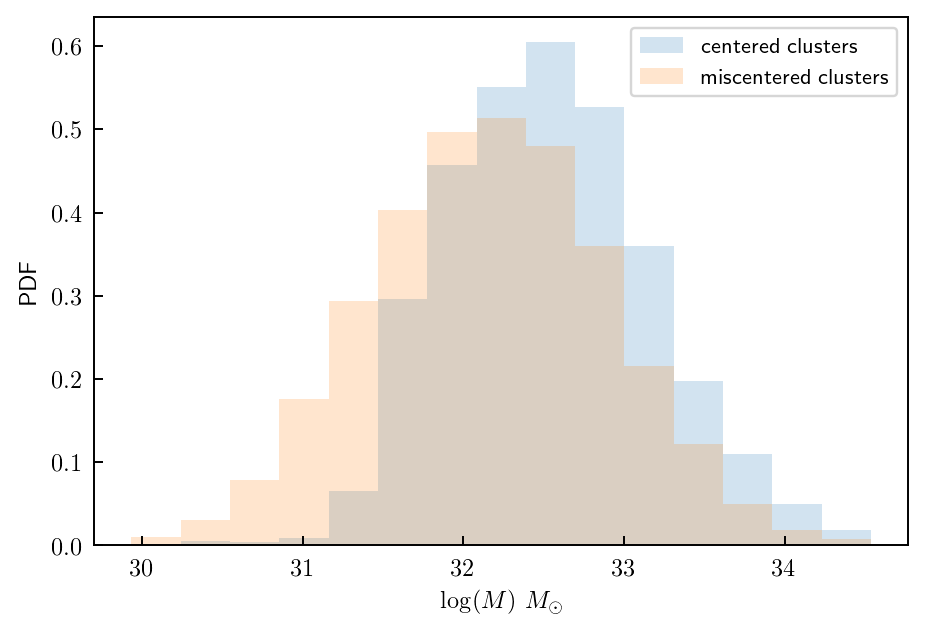

In [89]:
from tools.halo_mass_template import *
#Testing mass function
plt.figure(figsize=(6,4))
plt.hist(np.log(halos_cent.M200B), 15, (13*np.log(10), 15*np.log(10)), alpha=0.2, density=True, label='centered clusters')
plt.hist(np.log(halos_miscent.M200B), 15, (13*np.log(10), 15*np.log(10)), alpha=0.2, density=True, label='miscentered clusters')

lnM_arr = np.linspace(13*np.log(10), 15*np.log(10), 1000)
hmf_template, lnM_bin_cen = redMaPPer_hmf(lnM_arr)
#print hmf_template

#plt.hist(np.log(matched_halos['M200B']), 100, (13*np.log(10), 15*np.log(10)), density=True, label='all redM', alpha=0.3)

plt.legend(fontsize=9)
plt.ylabel('PDF')
plt.xlabel(r'$\log(M)$~$M_\odot$ ')
plt.show()

### Extracting parameters

In [67]:
##Shorthand name for relevant halo/redM parameters
#halos_ID_cent, q_cent, s_cent, cos_i_cent = read_shape_param(np.array(redM_cent), convcut=True)
richness = redM_cent.LAMBDA_CHISQ
halos_M  = halos_cent.M200B
lnl = np.log(richness)
lnM200b = np.log(halos_M)

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.009960531470597 15.356618541969091


### Binning by cos(i) and richness

### Generating tabulated hmf (for centered)

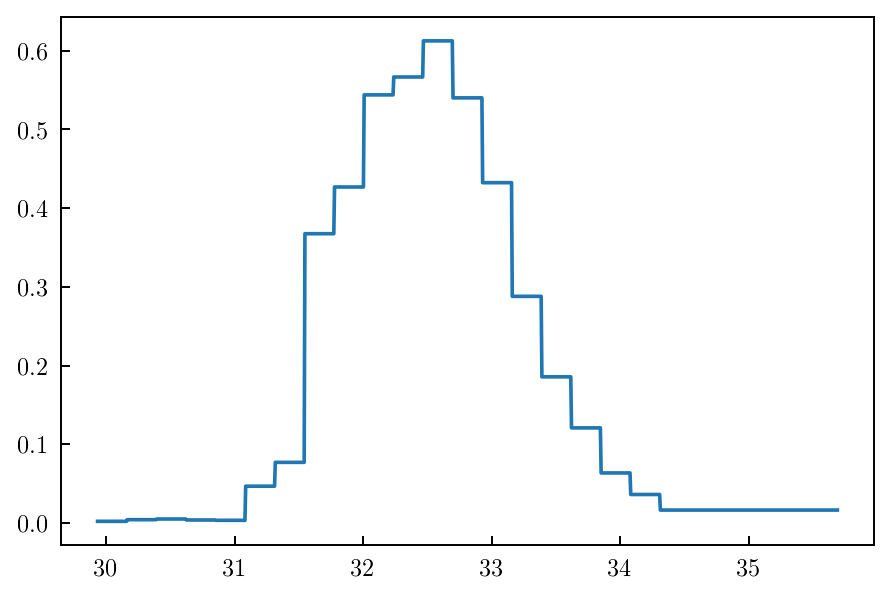

In [68]:
def input_hmf(lnM, lnM_min = 13*np.log(10), lnM_max=15*np.log(10), num_bins=20, lmda_bin=None):
    global lnM200b
    global lnM200b_binned
    
    lnM = np.array(lnM) #convert floats into array
    if len(np.shape(lnM))==0:
        lnM = lnM[np.newaxis]    
        
    if lmda_bin == None:
        hmf_lnM = lnM200b
    else:
        hmf_lnM = lnM200b_binned[lmda_bin]
    
    lnM_bin_edge = np.linspace(lnM_min, lnM_max, num_bins+1)   #.tolist()
    lnM_bin_cen = lnM_bin_edge[:-1] + (lnM_bin_edge[1] - lnM_bin_edge[0])/2.
    lnM_density = np.histogram(hmf_lnM, lnM_bin_edge, density=True)[0]    
    
    lnM_bin_num = np.array(np.searchsorted(lnM_bin_edge, lnM) - 1)
    lnM_bin_num[np.where(lnM_bin_num == -1)[0]] += 1 #for mass below smallest
    lnM_bin_num[np.where(lnM_bin_num == num_bins)[0]] -= 1 #for mass above highest 

    return lnM_density[lnM_bin_num], lnM_bin_cen

lnM_arr = np.linspace(13*np.log(10), 15.5*np.log(10), 1000)
hmf_cent, lnM_bin_cen  = input_hmf(lnM_arr)
plt.plot(lnM_arr, hmf_cent)

### Generating MCMC Chains

In [69]:
#MCMC chain setup
num=200
n_iter=num*3000
n_burn=num*200
n_thin=num    

'''
mcmc_filestr = range(len(cosi_bins))
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model1_centered'
    cosi_bin_ind_cent = cosi_bins_ind_cent[i]
    M=pymc.Model(make_model(hmf_cent, lnl_binned[i], lnM200b_binned[i]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)
'''

##For all 
mcmc_folder = tpltdir  + 'p_lmda_cosi_'+'all_'+'model1_centered_v1.2'
M=pymc.Model(make_model(hmf_cent, lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 600000 of 600000 complete in 1589.3 sec

## Running chains for miscentered clusters

In [70]:
##Shorthand name for relevant halo/redM parameters
#halos_ID_miscent, q_miscent, s_miscent, cos_i_miscent = read_shape_param(np.array(redM_miscent), convcut=True)
richness = redM_miscent.LAMBDA_CHISQ
halos_M  = halos_miscent.M200B
lnl = np.log(richness)
lnM200b = np.log(halos_M)

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.000564216165376 15.53186194909581


### Generating tabulated hmf (for miscentered)

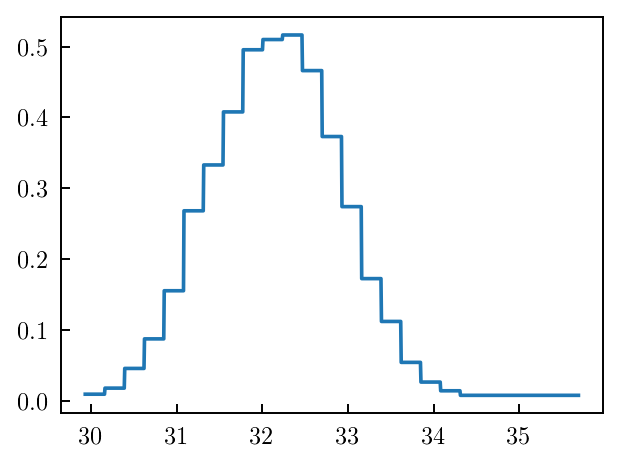

In [71]:
def input_hmf(lnM, lnM_min = 13*np.log(10), lnM_max=15*np.log(10), num_bins=20, lmda_bin=None):
    global lnM200b
    global lnM200b_binned
    
    lnM = np.array(lnM) #convert floats into array
    if len(np.shape(lnM))==0:
        lnM = lnM[np.newaxis]    
        
    if lmda_bin == None:
        hmf_lnM = lnM200b
    else:
        hmf_lnM = lnM200b_binned[lmda_bin]
    
    lnM_bin_edge = np.linspace(lnM_min, lnM_max, num_bins+1)   #.tolist()
    lnM_bin_cen = lnM_bin_edge[:-1] + (lnM_bin_edge[1] - lnM_bin_edge[0])/2.
    lnM_density = np.histogram(hmf_lnM, lnM_bin_edge, density=True)[0]    
    
    lnM_bin_num = np.array(np.searchsorted(lnM_bin_edge, lnM) - 1)
    lnM_bin_num[np.where(lnM_bin_num == -1)[0]] += 1 #for mass below smallest
    lnM_bin_num[np.where(lnM_bin_num == num_bins)[0]] -= 1 #for mass above highest 

    return lnM_density[lnM_bin_num], lnM_bin_cen

lnM_arr = np.linspace(13*np.log(10), 15.5*np.log(10), 1000)
hmf_miscent, lnM_bin  = input_hmf(lnM_arr)
plt.figure(figsize=(4,3))
plt.plot(lnM_arr, hmf_miscent)

### Generating MCMC Chains

In [72]:
#MCMC chain setup
num=200
n_iter=num*3000
n_burn=num*200
n_thin=num    

'''
mcmc_filestr = range(len(cosi_bins))
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model1'+'_miscentered'
    cosi_bin_ind_miscent = cosi_bins_ind_miscent[i]
    M=pymc.Model(make_model(hmf_miscent, lnl_binned[i], lnM200b_binned[i]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)
'''

##For all 
mcmc_folder = tpltdir  + 'p_lmda_cosi_'+'all_'+'model1_miscentered_v1.2'
M=pymc.Model(make_model(hmf_miscent, lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 600000 of 600000 complete in 1293.6 sec

## Comparison of posteriors

In [73]:
from scipy.stats import sem
c_cent = ChainConsumer() #contains multiple chains across different models

### For centered

In [75]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model1_centered_v1.2'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

# plot the parameter constraints
data=np.vstack( (As, Bs, sig0s) ).T
c_cent.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 centered')
c_cent.configure(statistics="max_shortest")
c_cent = c_cent.analysis.get_summary()



### For miscentered

In [76]:
c_miscent = ChainConsumer()

In [77]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model1_miscentered_v1.2'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

# plot the parameter constraints
data=np.vstack( (As, Bs, sig0s) ).T
c_miscent.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 miscentered')
c_miscent.configure(statistics="max_shortest")
c_miscent = c_miscent.analysis.get_summary()



### Plotting results

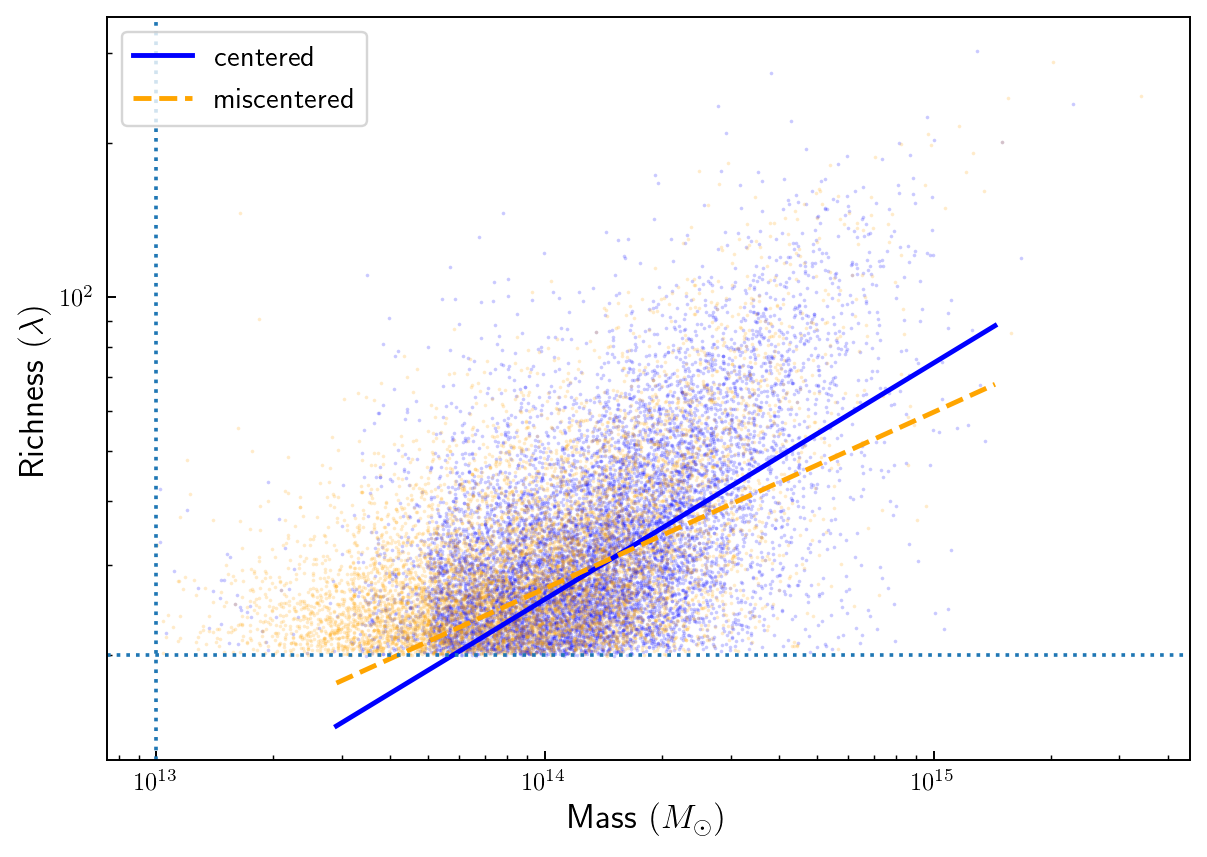

In [84]:
#Posterior likelihoods
lnA_post_model1_cent = np.zeros(3)
B_post_model1_cent = np.zeros(3)
sig0_post_model1_cent = np.zeros(3)

lnA_post_model1_miscent = np.zeros(3)
B_post_model1_miscent = np.zeros(3)
sig0_post_model1_miscent = np.zeros(3)


#For centered
lnA_post_model1_cent = np.log(c_cent["$A$"])
B_post_model1_cent = c_cent["$B$"]
sig0_post_model1_cent = c_cent["$\sigma_0$"]

lnA_post_model1_miscent = np.log(c_miscent["$A$"])
B_post_model1_miscent = c_miscent["$B$"]
sig0_post_model1_miscent = c_miscent["$\sigma_0$"]


#x parameters are the mean of each cosi_bin
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_cent.M200B, redM_cent.LAMBDA_CHISQ, 'k.', markersize=1, alpha=0.2,color='blue')
axs.plot(halos_miscent.M200B, redM_miscent.LAMBDA_CHISQ, 'k.', markersize=1, alpha=0.2,color='orange')

lnM_range = np.arange(31,35,0.1)
#For centered
i=0
lnA_cosi_maxL = lnA_post_model1_cent[1]; 
B_cosi_maxL = B_post_model1_cent[1];
sig0_cosi_maxL = sig0_post_model1_cent[1]
mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='solid', \
        label='centered', color='blue')

#For miscentered
lnA_cosi_maxL = lnA_post_model1_miscent[1]; 
B_cosi_maxL = B_post_model1_miscent[1];
sig0_cosi_maxL = sig0_post_model1_miscent[1]
mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='miscentered', color='orange')
             

axs.axhline(20, linestyle='dotted')
axs.axvline(1e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
#axs.set_ylim((15,600))
#axs.set_xlim((4e13,2e15))




#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')

plt.show()


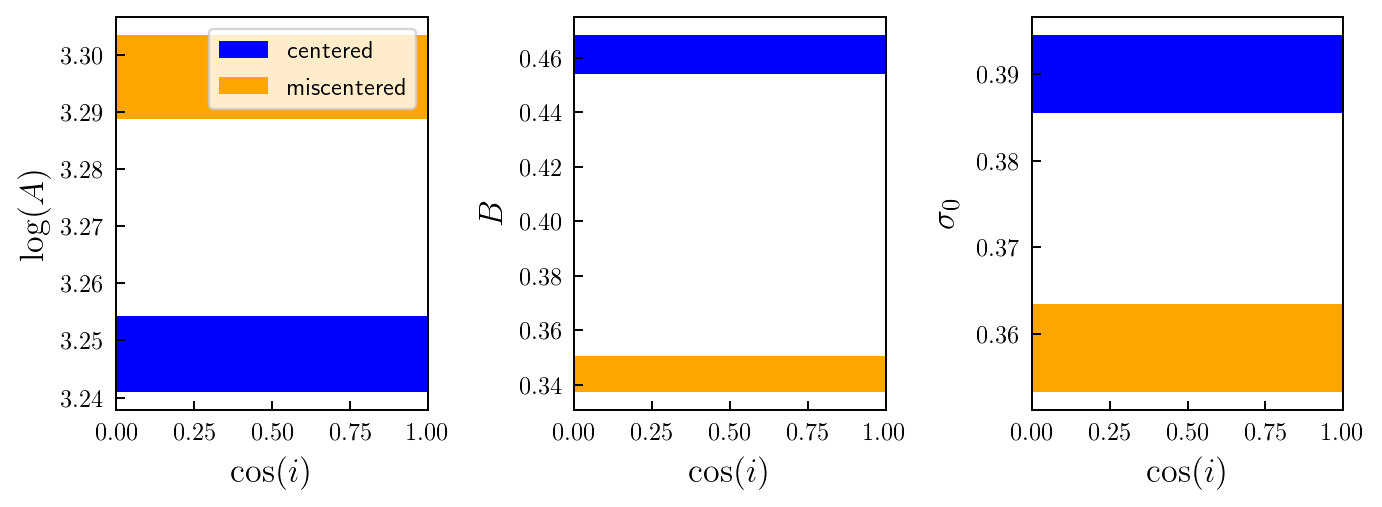

In [87]:
#Posterior. For each paramater array contains 3 indexes -- low, max posterior, and high range. 


#Plotting the posteriors #########################################################
#Plotting posterior for lnA
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(8,3))
subtitles = [r'$\log(A)$', r'$B$', r'$\sigma_0$']
stat_name = ["$A$", "$B$", "$\sigma_0$"]
xband = np.linspace(0,1,5)

#posterior for A
axs[0].fill_between(xband, lnA_post_model1_cent[0], lnA_post_model1_cent[2], \
                facecolor='blue', interpolate=False, label='centered')  

axs[0].fill_between(xband, lnA_post_model1_miscent[0], lnA_post_model1_miscent[2], \
                facecolor='orange', interpolate=False, label='miscentered')  

#posterior for B
axs[1].fill_between(xband, B_post_model1_cent[0], B_post_model1_cent[2], \
                facecolor='blue', interpolate=False, label='centered')  

axs[1].fill_between(xband, B_post_model1_miscent[0], B_post_model1_miscent[2], \
                facecolor='orange', interpolate=False, label='miscentered')  


#posterior for sigma0
axs[2].fill_between(xband, sig0_post_model1_cent[0], sig0_post_model1_cent[2], \
                facecolor='blue', interpolate=False, label='centered')  

axs[2].fill_between(xband, sig0_post_model1_miscent[0], sig0_post_model1_miscent[2], \
                facecolor='orange', interpolate=False, label='miscentered')  
                      

for i in range(3):
    axs[i].set_xlim((0,1))
    #axs[i].set_xticks(x_pos)
    axs[i].set_ylabel(subtitles[i], size=14)
    axs[i].set_xlabel(r'$\cos(i)$', size=14) 

axs[2].set_xlabel(r'$\cos(i)$', size=14) 
axs[0].legend(fontsize=10)
#plt.savefig('richness_mass_modelparams_cosibinned_060718.png')
plt.show()

### Trendlines


IndexError: too many indices for array

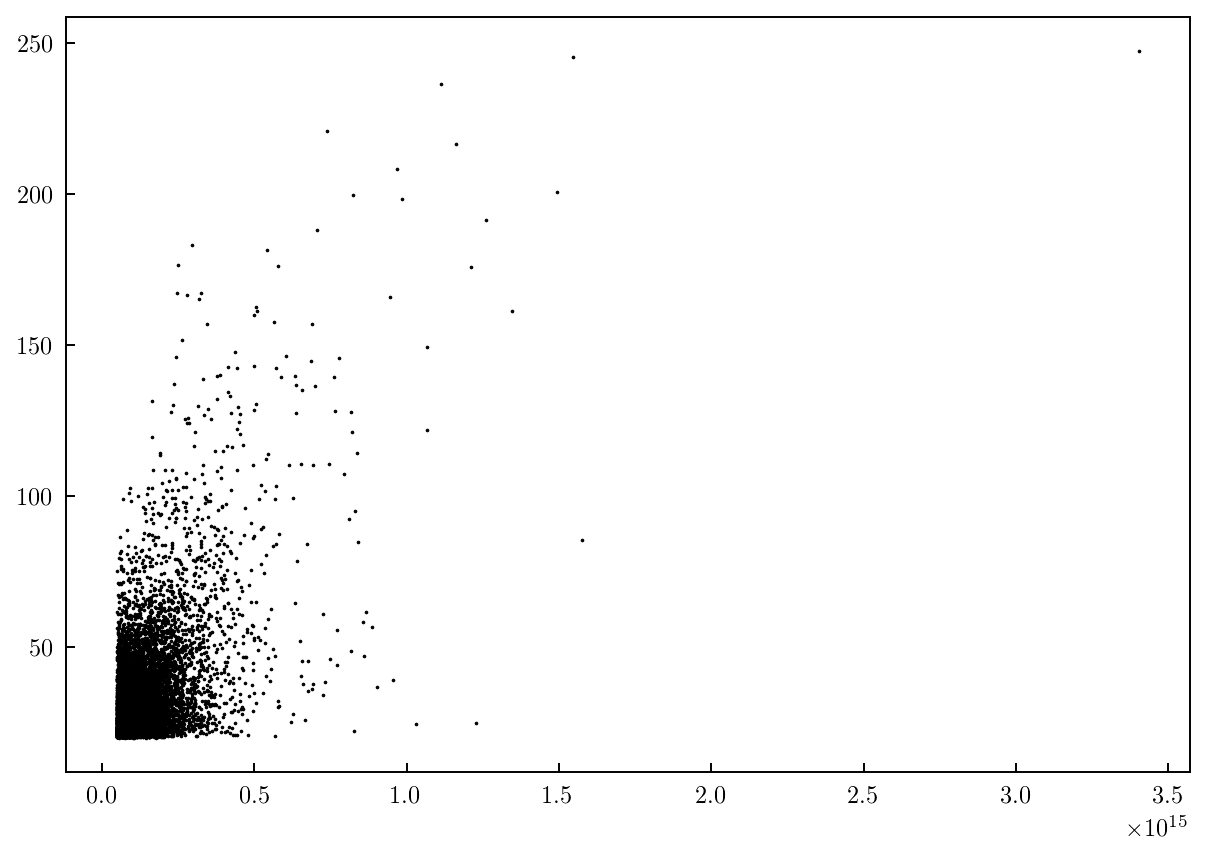

In [21]:
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model1_cent[i,1]; 
    B_cosi_maxL = B_post_model1_cent[i,1];
    sig0_cosi_maxL = sig0_post_model1_cent[i,1]
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max))
             

axs.axhline(20, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((15,600))
axs.set_xlim((4e13,2e15))

'''
#Add an inset to show difference between lines
a = plt.axes([0.62, 0.2, .3, .3])
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', alpha=1)
plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), label='Combined', linewidth=2)
#plt.plot(halos_M, richness, 'k.', markersize=2)
plt.yscale('log'); plt.xscale('log')
plt.xlim((2.2e14, 3e14)); plt.ylim((47,60))   
plt.xticks((2.2e14, 3e14), (r'$2.2 \times 10^{14}$', r'$3 \times 10^{14}$'))
#plt.yticks([])
'''

#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')

plt.show()

## Shape information

In [ ]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(3,3))
num_bin = np.linspace(0.0,1.0,15)

####Centered halos########
lmda_bin_num = len(lmda_bins_ind_cent)
weights_cent = np.ones_like(q_cent, dtype=float)/len(q_cent)* 100
axs.hist(cos_i_cent, num_bin, density=False, fill=False, weights=weights_cent, histtype='step', label="Centered") 


####miscentered halos########
lmda_bin_num = len(lmda_bins_ind_miscent)
weights_miscent = np.ones_like(q_miscent, dtype=float)/len(q_miscent)* 100
axs.hist(cos_i_miscent, num_bin, density=False, fill=False, weights=weights_miscent, histtype='step', label="miscentered") 

#axs.set_ylim((0,60))
axs.legend(loc='upper left', fontsize=12, frameon=False)

axs.set_xlabel(r'$\cos{i}$', size=15)
axs.set_ylabel('$p(\cos{i})$', size=15)
plt.show()
    